In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
news_dir = './dataset/bagidata_task/News Title.xls'
spam_dir = './dataset/bagidata_task/Comment Spam.xls'

## export data

In [3]:
news_df = pd.read_excel(news_dir)

In [4]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   No          65535 non-null  int64 
 1   News Title  65535 non-null  object
 2   Category    65535 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


## delete unneccessary column

In [5]:
news_df = news_df.drop(columns=['No'])

In [6]:
news_df['Category'] = news_df['Category'].astype('category')
news_df['Cat Code'] = news_df['Category'].cat.codes

In [7]:
def category_code_relation(df, category_colum_name, cat_code_column_name, cat_codes):
    dict_cat_code_relation = dict()
    for cat_code in cat_codes:
        category = df[category_colum_name][df[cat_code_column_name] == cat_code].values[0]
        dict_cat_code_relation[category] = cat_code
    return dict_cat_code_relation

In [8]:
cat_codes = news_df['Cat Code'].unique()
code_relation = category_code_relation(news_df,'Category','Cat Code',cat_codes)
code_relation

{'Technology': 3, 'Business': 0, 'Entertainment': 1, 'Medical': 2}

In [9]:
news_df

,News Title,Category,Cat Code
0,Google+ rolls out 'Stories' for tricked out ph...,Technology,3
1,Dov Charney's Redeeming Quality,Business,0
2,White God adds Un Certain Regard to the Palm Dog,Entertainment,1
3,"Google shows off Androids for wearables, cars,...",Technology,3
4,China May new bank loans at 870.8 bln yuan,Business,0
...,...,...,...
65530,Xbox One Homebrew Will Likely Be a Reality in ...,Technology,3
65531,Maker Recalls 1.9 Million Rear-Facing Infant S...,Technology,3
65532,Watch first 'Ninja Turtles' trailer,Entertainment,1
65533,23/05/2014Dogs triumph in Cannes as canine thr...,Entertainment,1


## checking na value

In [10]:
news_df.isna().sum()

News Title    0
Category      0
Cat Code      0
dtype: int64

## plot count category

<AxesSubplot:xlabel='Category', ylabel='count'>

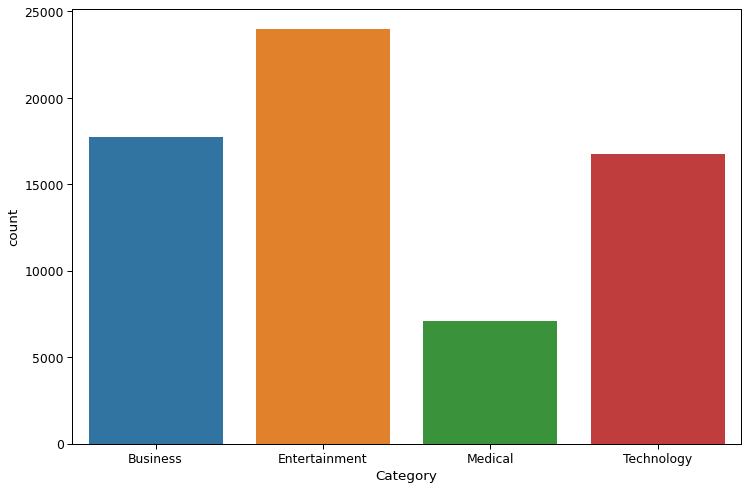

In [11]:
plt.figure(figsize=(12,8))
sns.set_context('paper',font_scale=1.4)
sns.countplot(x='Category', data=news_df)

In [12]:
def word_cloud(df, text_column, category_code_column, category_code):
    topic = df[text_column][df[category_code_column] == category_code].values
    topic_words = ''
    for statement in topic:
        text = statement.lower()
        token = word_tokenize(text)
        for word in token:
            topic_words = topic_words + word + ' '
            
    topic_word_cloud = WordCloud(width=600, height=400).generate(topic_words)
    return topic_word_cloud

In [166]:
dict_word_cloud = dict()
for category, code in code_relation.items():    
    wc = word_cloud(news_df,'News Title','Cat Code',code)
    dict_word_cloud[category] = wc

## word cloud

word cloud Business


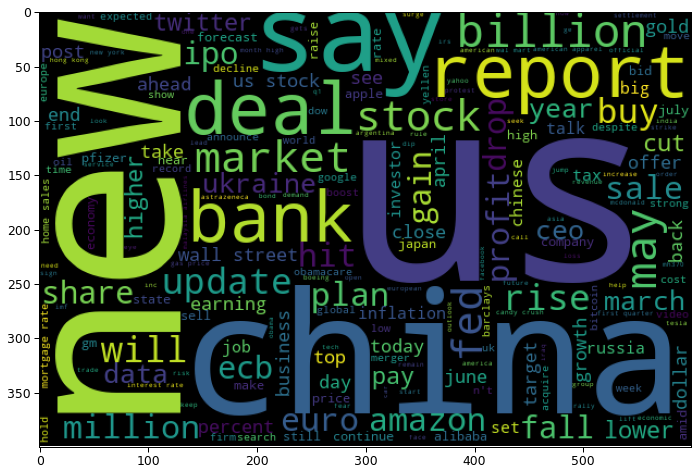

In [167]:
print('word cloud Business')
plt.figure(figsize=(13,8))
plt.imshow(dict_word_cloud['Business'])

word cloud Entertainment


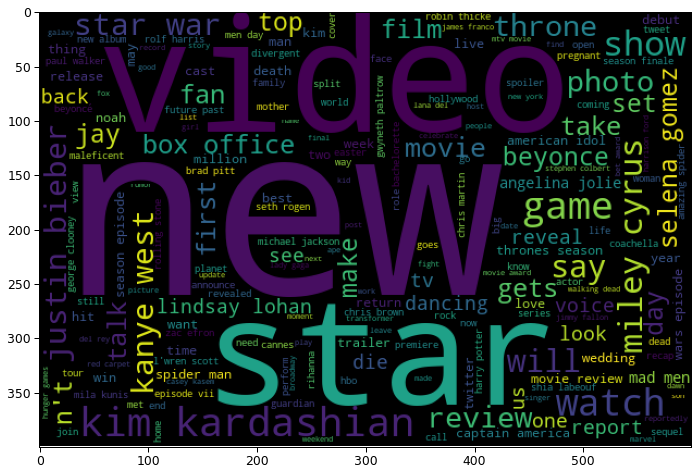

In [168]:
print('word cloud Entertainment')
plt.figure(figsize=(13,8))
plt.imshow(dict_word_cloud['Entertainment'])

word cloud Medical


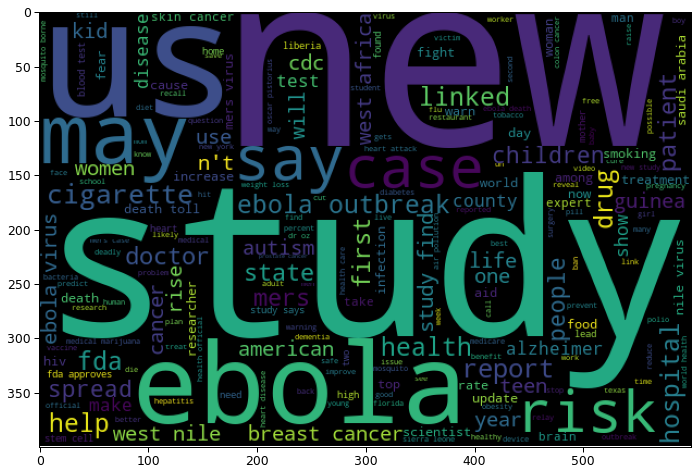

In [169]:
print('word cloud Medical')
plt.figure(figsize=(13,8))
plt.imshow(dict_word_cloud['Medical'])

word cloud Technology


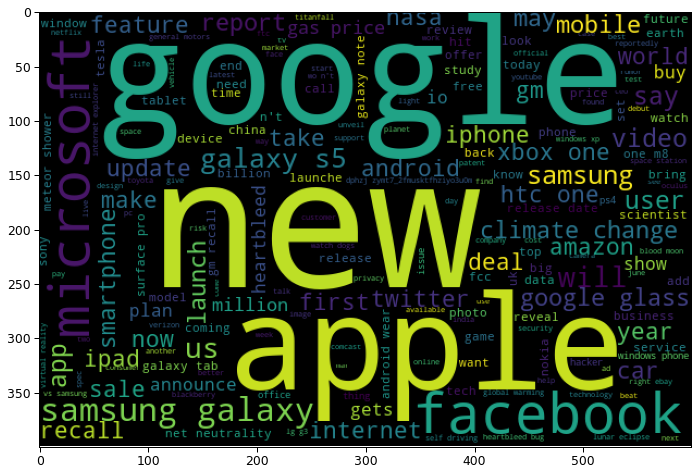

In [170]:
print('word cloud Technology')
plt.figure(figsize=(13,8))
plt.imshow(dict_word_cloud['Technology'])

In [13]:
news_df['News Title Length'] = news_df['News Title'].apply(lambda x: len(x))
news_df.head()

,News Title,Category,Cat Code,News Title Length
0,Google+ rolls out 'Stories' for tricked out ph...,Technology,3,58
1,Dov Charney's Redeeming Quality,Business,0,31
2,White God adds Un Certain Regard to the Palm Dog,Entertainment,1,48
3,"Google shows off Androids for wearables, cars,...",Technology,3,50
4,China May new bank loans at 870.8 bln yuan,Business,0,42


<AxesSubplot:xlabel='Category', ylabel='News Title Length'>

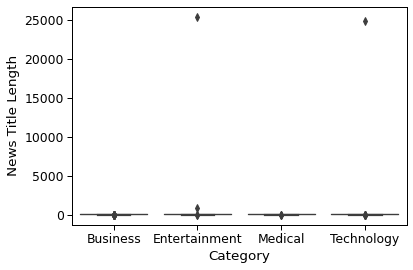

In [14]:
sns.set_context('paper',font_scale=1.4)
sns.boxplot(x='Category',y='News Title Length',data=news_df)

In [15]:
outlier_index = news_df[news_df['News Title Length']>500].index
outlier_index

Int64Index([29159, 53162, 62852], dtype='int64')

## minimize outlier of news title length

In [16]:
news_df = news_df.drop(outlier_index)

<AxesSubplot:xlabel='Category', ylabel='News Title Length'>

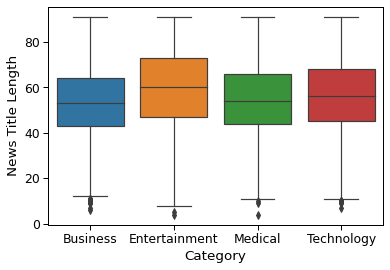

In [17]:
sns.boxplot(x='Category',y='News Title Length',data=news_df)

In [18]:
vectorizer = TfidfVectorizer()
news_title_vector = vectorizer.fit_transform(news_df['News Title'])
news_title_vector.shape

(65532, 27489)

In [19]:
X_train,X_test,Y_train,Y_test = train_test_split(
    news_title_vector, news_df['Category'],test_size=0.2)

## trying some classifier

In [20]:
clf_nb=MultinomialNB().fit(X_train,Y_train)

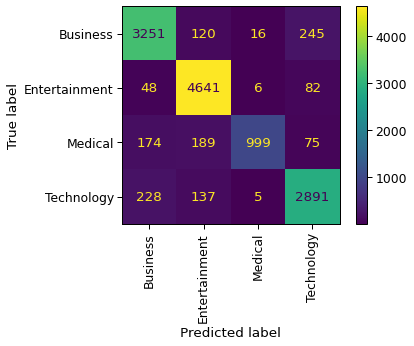

In [21]:
plot_confusion_matrix(clf_nb, X_test, Y_test)
plt.xticks(rotation ='vertical')
plt.show()

In [22]:
predict_nb = clf_nb.predict(X_test)
accuracy_score(Y_test, predict_nb)

0.8989089799343862

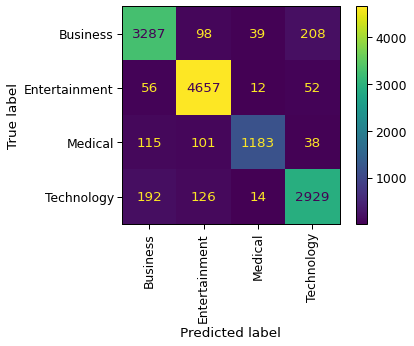

In [23]:
clf_lg = LogisticRegression(max_iter=3000,solver='saga').fit(X_train,Y_train)
plot_confusion_matrix(clf_lg, X_test, Y_test)
plt.xticks(rotation ='vertical')
plt.show()

In [24]:
predict_lg = clf_lg.predict(X_test)
accuracy_score(Y_test, predict_lg)

0.9198138399328603

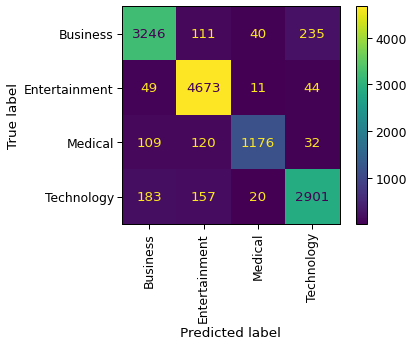

In [25]:
clf_sgd = SGDClassifier().fit(X_train,Y_train)
plot_confusion_matrix(clf_sgd, X_test, Y_test)
plt.xticks(rotation ='vertical')
plt.show()

In [26]:
predict_sgd = clf_sgd.predict(X_test)
accuracy_score(Y_test, predict_sgd)

0.9152361333638513

## testing real world news

In [116]:
# get from https://www.msn.com/en-us/money/other/sony-will-optimize-ps5-fan-performance-with-software-updates-using-individual-game-data/ar-BB1aaYL7
tech_news = '''
Sony will optimize PS5 fan performance with software updates using individual game data
'''

# get from https://www.eonline.com/de/news/1199669/hannah-brown-asks-out-cute-mystery-man-by-leaving-her-phone-number-on-his-car
entertainment_news = '''
Hannah Brown Asks Out "Cute" Mystery Man by Leaving Her Phone Number on His Car
'''

# get from https://www.nasdaq.com/articles/canada-stocks-tsx-flat-as-energy-losses-offset-gains-from-materials-stimulus-hopes-2020-10
business_news = '''
CANADA STOCKS-TSX flat as energy losses offset gains from materials, stimulus hopes
'''

# get from https://www.cbsnews.com/video/covid-19-straining-utah-medical-system-as-cases-continue-to-rise/
medical_news = '''
COVID-19 straining Utah medical system as cases continue to rise
'''

list_news = [tech_news, entertainment_news, business_news, medical_news]

In [28]:
real_input = vectorizer.transform(list_news)
prediction = clf_lg.predict(real_input)
prediction

array(['Technology', 'Entertainment', 'Business', 'Medical'], dtype=object)

## thank you

In [158]:
train_labels = pd.get_dummies(news_df['Cat Code']).values

In [159]:
train_labels, train_samples = shuffle(train_labels, news_df['News Title'])

In [160]:
X_train,X_test,Y_train,Y_test = train_test_split(
    train_samples, train_labels,test_size=0.2)

In [161]:
X_train

8384     Jenny McCarthy Lines Up New Talk Show After Ex...
49187    Jefferson Co. resident contracts 5th case of C...
7939                      YOUR TAKE: Ford Mustang turns 50
47958    Rice Theory: Why Eastern Cultures Are More Coo...
31607    Calder Sloan, 'Mr. Awesome': Push for child's ...
                               ...                        
37711       Boy's rash is traced to nickel in iPad coating
17681    The dollar index steadied, rising about 0.2 pe...
53204      FCC Blames Net-Neutrality Glitch on Budget Woes
38481            Wal-Mart Recalls Dolls Due to Burn Hazard
41651    Amazon Kindle Unlimited now official, offers 6...
Name: News Title, Length: 52425, dtype: object

In [162]:
max_length = 20 #arbitrary number that represent the estimation of maximum words in one news

In [163]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [164]:
tokenizer.word_index

{'to': 1,
 'in': 2,
 'the': 3,
 'of': 4,
 'for': 5,
 'on': 6,
 'and': 7,
 'a': 8,
 'with': 9,
 'new': 10,
 'at': 11,
 'is': 12,
 'us': 13,
 'as': 14,
 'from': 15,
 'after': 16,
 'by': 17,
 'up': 18,
 'google': 19,
 'be': 20,
 'video': 21,
 '2014': 22,
 'apple': 23,
 'says': 24,
 'over': 25,
 '2': 26,
 'will': 27,
 'first': 28,
 'more': 29,
 '1': 30,
 'may': 31,
 'samsung': 32,
 'one': 33,
 '4': 34,
 '3': 35,
 'about': 36,
 'not': 37,
 'you': 38,
 'out': 39,
 'it': 40,
 '5': 41,
 'are': 42,
 'report': 43,
 'watch': 44,
 'galaxy': 45,
 'kim': 46,
 'facebook': 47,
 'this': 48,
 'microsoft': 49,
 'season': 50,
 'review': 51,
 'day': 52,
 'your': 53,
 'deal': 54,
 'million': 55,
 'but': 56,
 'kardashian': 57,
 'china': 58,
 "'the": 59,
 'off': 60,
 'star': 61,
 'year': 62,
 'has': 63,
 'could': 64,
 'its': 65,
 'sales': 66,
 'update': 67,
 'how': 68,
 'her': 69,
 '7': 70,
 'time': 71,
 'amazon': 72,
 'that': 73,
 'what': 74,
 'movie': 75,
 's': 76,
 'study': 77,
 'west': 78,
 'tv': 79,
 '6'

In [165]:
max_index = max([x for x in tokenizer.word_index.values()]) + 1
max_index

31443

In [166]:
train_sequence = tokenizer.texts_to_sequences(X_train)
train_sequence[0]

[1085, 830, 3938, 18, 10, 893, 89, 16, 8856, 3, 550]

In [167]:
train_padded = pad_sequences(train_sequence, maxlen=max_length ,padding='post', truncating='post')

In [168]:
train_padded[0]

array([1085,  830, 3938,   18,   10,  893,   89,   16, 8856,    3,  550,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [169]:
test_sequence = tokenizer.texts_to_sequences(X_test)

In [170]:
test_padded = pad_sequences(test_sequence, maxlen=max_length ,padding='post', truncating='post')

In [171]:
model = Sequential([
    Embedding(max_index, 32, input_length=max_length),
    LSTM(64, dropout=0.1),
    Dense(units=4,activation='softmax')
])

In [172]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 32)            1006176   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 1,031,268
Trainable params: 1,031,268
Non-trainable params: 0
_________________________________________________________________


In [173]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [174]:
Y_test

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]], dtype=uint8)

In [175]:
model.fit(
    x=train_padded,
    y=Y_train,
    validation_data=(test_padded, Y_test),
    batch_size=100,
    epochs=20,
    verbose=2
)

Epoch 1/20
525/525 - 10s - loss: 1.1968 - accuracy: 0.4215 - val_loss: 0.8759 - val_accuracy: 0.6627
Epoch 2/20
525/525 - 10s - loss: 0.6744 - accuracy: 0.7471 - val_loss: 0.5806 - val_accuracy: 0.7891
Epoch 3/20
525/525 - 11s - loss: 0.4942 - accuracy: 0.8247 - val_loss: 0.4891 - val_accuracy: 0.8282
Epoch 4/20
525/525 - 12s - loss: 0.3672 - accuracy: 0.8726 - val_loss: 0.4004 - val_accuracy: 0.8540
Epoch 5/20
525/525 - 12s - loss: 0.2735 - accuracy: 0.9061 - val_loss: 0.3598 - val_accuracy: 0.8718
Epoch 6/20
525/525 - 12s - loss: 0.2204 - accuracy: 0.9279 - val_loss: 0.3450 - val_accuracy: 0.8801
Epoch 7/20
525/525 - 12s - loss: 0.1848 - accuracy: 0.9400 - val_loss: 0.3463 - val_accuracy: 0.8843
Epoch 8/20
525/525 - 12s - loss: 0.1605 - accuracy: 0.9494 - val_loss: 0.3451 - val_accuracy: 0.8904
Epoch 9/20
525/525 - 12s - loss: 0.1418 - accuracy: 0.9551 - val_loss: 0.3449 - val_accuracy: 0.8923
Epoch 10/20
525/525 - 12s - loss: 0.1268 - accuracy: 0.9602 - val_loss: 0.3471 - val_accura

In [176]:
real_sequence = tokenizer.texts_to_sequences(list_news)

In [177]:
real_sequence

[[361, 27, 1142, 1081, 9, 1677, 1271, 935, 11681, 106, 86],
 [22169, 469, 1260, 39, 4706, 1469, 126, 17, 958, 69, 191, 1187, 6, 102, 256],
 [1199, 83, 4755, 1211, 14, 737, 1623, 6535, 437, 15, 6775, 2018, 1690],
 [1216, 4715, 677, 770, 14, 482, 891, 1, 151]]

In [178]:
real_padded = pad_sequences(real_sequence, maxlen=max_length ,padding='post', truncating='post')

In [179]:
predictions = model.predict(real_padded)

In [180]:
np.argmax(predictions, axis=-1)

array([3, 1, 0, 2])